In [1]:
%%capture
!apt-get update
!apt-get install --reinstall build-essential --yes

In [2]:
%%capture
!pip install bertopic==0.11.0
!pip install farm-haystack
!pip install spacy
!pip install gensim
!pip install sagemaker_pyspark
!python -m spacy download en_core_web_sm
!pip install joblib==1.1.0

In [3]:
%%capture
!pip install wordcloud

In [4]:
import re
import string
import pickle
import logging
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from nltk.corpus import stopwords
from haystack.nodes import PreProcessor
from nltk.corpus import PlaintextCorpusReader
from haystack.utils import convert_files_to_docs
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel

pio.renderers.default='iframe'
logging.getLogger("haystack.utils.preprocessing").setLevel(logging.ERROR)

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [5]:
import nltk

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('omw-1.4')
token_pattern = re.compile(r"(?u)\b\w\w+\b")
sentence_model = SentenceTransformer("all-distilroberta-v1")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if (len(t) > 3 and re.match("[a-z].*", t) and re.match(token_pattern, t)) or (t=='ai')
        ]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedantgupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vedantgupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# This is the model path will need to change this so that code works, just give the path of the model.
output_path = r"Model Files/BERT_DTM/"
topic_model = BERTopic.load(output_path+"bert_dtm_model")

In [7]:
with open(output_path+'bert_dtm_timestamps.pkl', 'rb') as f:
    timestamps = pickle.load(f)
with open(output_path+'bert_dtm_prob.pkl', 'rb') as f:
    prob = pickle.load(f)
with open(output_path+'bert_dtm_coherence.pkl', 'rb') as f:
    coherence = pickle.load(f)
with open(output_path+'bert_dtm_topics.pkl', 'rb') as f:
    topic = pickle.load(f)
with open(output_path+'bert_dtm_hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output_path+'bert_dtm_docs.pkl', 'rb') as f:
    docs = pickle.load(f)

#### Topic Representation

In [9]:
# Merge Topics in topic model
topics_to_merge = [-1, 7]
topic_model.merge_topics(docs, topic, topics_to_merge)

In [10]:
# all topics
topic_model.get_topics()

{-1: [('company', 0.018680864550194742),
  ('state', 0.011416335617119787),
  ('people', 0.01092607291445773),
  ('business', 0.010502122799530257),
  ('percent', 0.010345138591672593),
  ('work', 0.010004291155746657),
  ('worker', 0.009948796777173387),
  ('million', 0.00983347375529115),
  ('system', 0.009325872384347398),
  ('computer', 0.009006806243664272)],
 0: [('company', 0.01757775597285034),
  ('system', 0.011427072213867809),
  ('worker', 0.010818741858728493),
  ('state', 0.010361299692986605),
  ('industry', 0.01010026097490434),
  ('people', 0.010051501702821349),
  ('computer', 0.009689907139950478),
  ('work', 0.00959011615529488),
  ('union', 0.009583722331142932),
  ('american', 0.009468396599381016)],
 1: [('theater', 0.02092670534592006),
  ('music', 0.019435637430036165),
  ('directed', 0.019012641035572708),
  ('closed', 0.01637378012502203),
  ('show', 0.016006796632377314),
  ('street', 0.014542017777238413),
  ('city', 0.013939926704850149),
  ('york', 0.01307

In [11]:
# listing all topics
for i in range(18):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('company', 0.018680864550194742), ('state', 0.011416335617119787), ('people', 0.01092607291445773), ('business', 0.010502122799530257), ('percent', 0.010345138591672593), ('work', 0.010004291155746657), ('worker', 0.009948796777173387), ('million', 0.00983347375529115), ('system', 0.009325872384347398), ('computer', 0.009006806243664272)]

Topic Info:
   Topic  Count                              Name
0     -1   5246  -1_company_state_people_business

Topic 0:

Representative Words:
[('company', 0.01757775597285034), ('system', 0.011427072213867809), ('worker', 0.010818741858728493), ('state', 0.010361299692986605), ('industry', 0.01010026097490434), ('people', 0.010051501702821349), ('computer', 0.009689907139950478), ('work', 0.00959011615529488), ('union', 0.009583722331142932), ('american', 0.009468396599381016)]

Topic Info:
    Topic  Count                                  Name
0      -1   5246      -1_company_state_people_business
1       0   44

#### Visualize Topics

In [14]:
# change this for storing the results in some other folder
folder_path = r'/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/Results/BERTDTM_FIGURES/'

In [15]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'Intertopic_Distance_Map.html')

In [16]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=17)
fig.write_html(folder_path+'Topic_Word_Score.html')

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [28]:
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


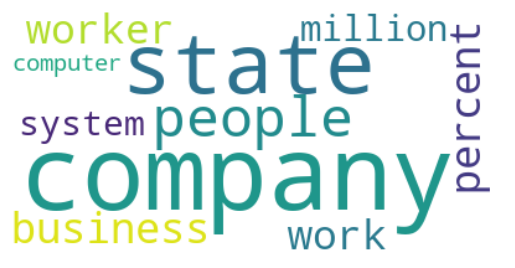

******************************
Topic: 0


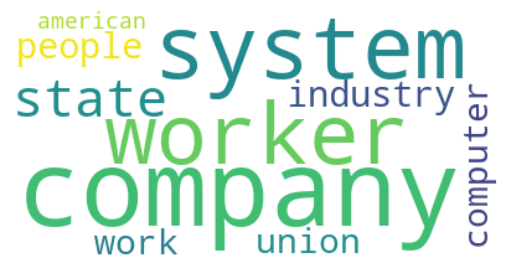

******************************
Topic: 1


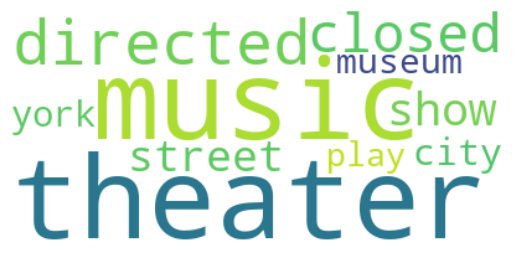

******************************
Topic: 2


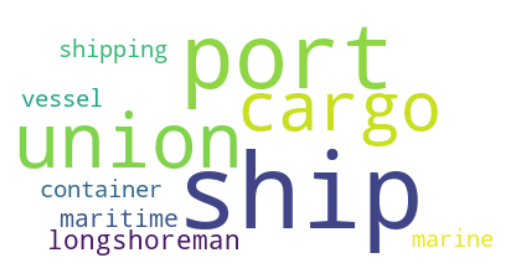

******************************
Topic: 3


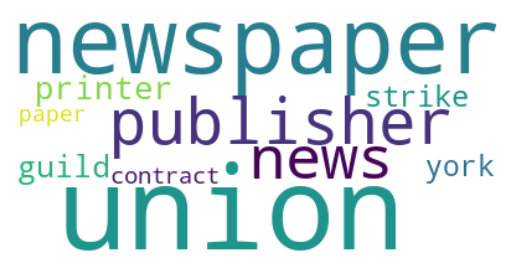

******************************
Topic: 4


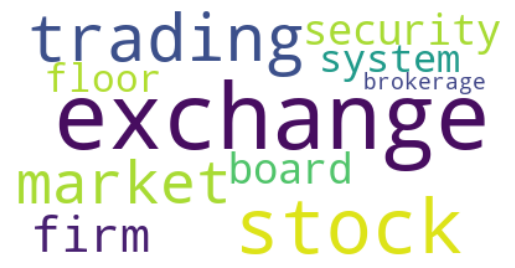

******************************
Topic: 5


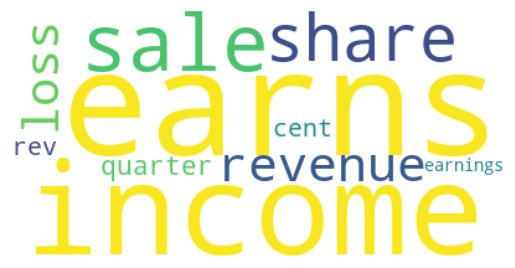

******************************
Topic: 6


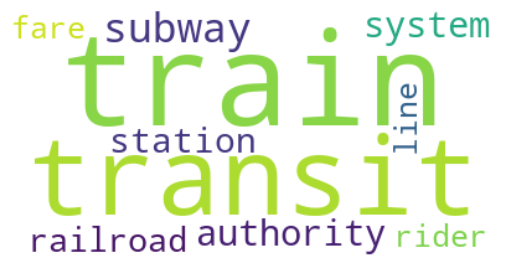

******************************
Topic: 7


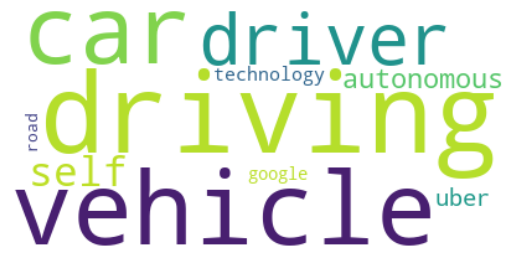

******************************
Topic: 8


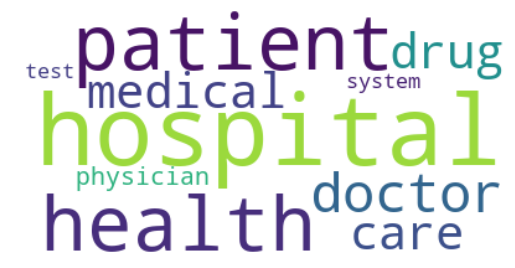

******************************
Topic: 9


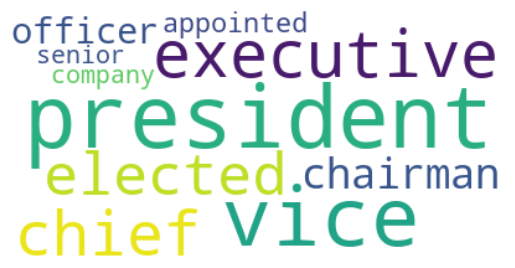

******************************
Topic: 10


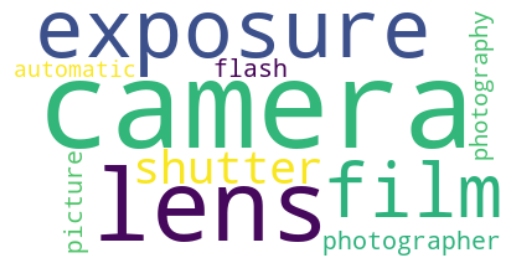

******************************
Topic: 11


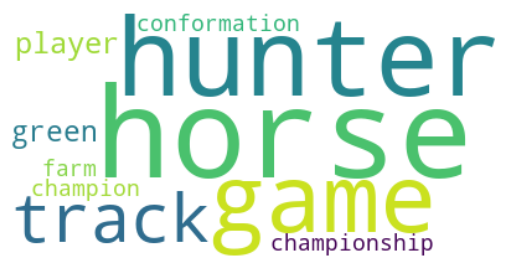

******************************
Topic: 12


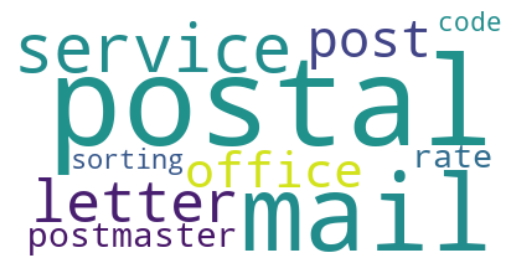

******************************
Topic: 13


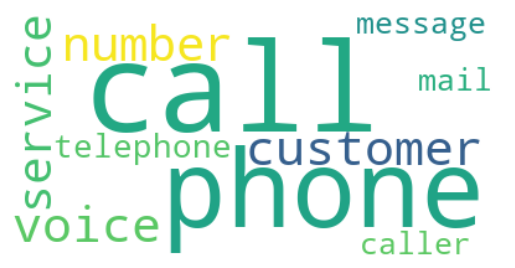

******************************
Topic: 14


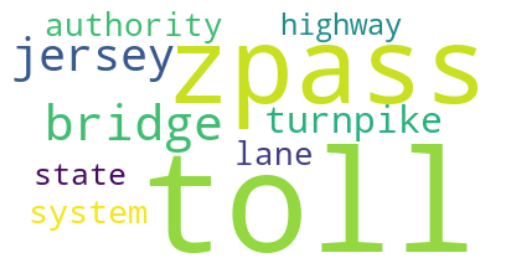

******************************
Topic: 15


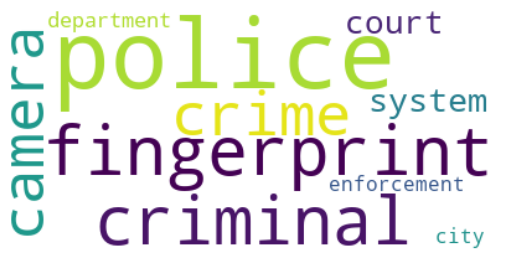

******************************


In [29]:
# word cloud for each topic
for i in range(17):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [51]:
# Removing topic 7
for i in range(len(topic)):
    if topic[i] < 7:
        continue
    else:
        if topic[i] == 7:
            topic[i] = -1
        else:
            topic[i] -= 1

In [55]:
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.88it/s]


In [56]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'Hierarchical_Clustering.html')

In [57]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)

In [58]:
print(tree)

.
├─earns_income_sale_share_president
│    ├─■──earns_income_sale_share_revenue ── Topic: 5
│    └─■──president_vice_executive_chief_elected ── Topic: 9
└─company_union_system_york_work
     ├─company_union_system_york_work
     │    ├─exchange_stock_trading_market_system
     │    │    ├─■──postal_mail_service_letter_post ── Topic: 12
     │    │    └─exchange_stock_trading_market_system
     │    │         ├─hospital_patient_health_doctor_care
     │    │         │    ├─■──call_phone_customer_voice_number ── Topic: 13
     │    │         │    └─■──hospital_patient_health_doctor_drug ── Topic: 8
     │    │         └─■──exchange_stock_trading_market_firm ── Topic: 4
     │    └─company_union_system_work_york
     │         ├─union_newspaper_ship_york_strike
     │         │    ├─■──union_newspaper_publisher_news_printer ── Topic: 3
     │         │    └─■──ship_port_union_cargo_longshoreman ── Topic: 2
     │         └─company_system_work_state_people
     │              ├─company_sys

In [46]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'Heat_Map.html')

In [47]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'Term_Score_Decline.html')

In [48]:
fig = topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'Term_Score_Decline_log_scale.html')

In [49]:
# topic prob distribution
fig = topic_model.visualize_distribution(prob[0], min_probability=0)
fig.write_html(folder_path+'Prob_distribution.html')

In [59]:
# topic over time
topics_over_time = topic_model.topics_over_time(docs=docs, 
                                                topics=topic, 
                                                timestamps=timestamps, 
                                                )

7it [02:00, 17.21s/it]


In [60]:
fig = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50, normalize_frequency=False)
fig.write_html(folder_path+'Topics_Over_Time.html')

In [62]:
def compare_topic_freq(topic_to_compare_with, topic_being_compared, normalize_freq = False):
    ''' You can compare the freq of topics you want.
        topic_to_compare_with -> INT
        topic_being_compared -> List[INT]
        normalize_freq -> bool
    '''
    topic_being_compared.append(topic_to_compare_with)
    return topic_model.visualize_topics_over_time(topics_over_time, normalize_frequency=normalize_freq, topics=topic_being_compared)

In [63]:
def get_comparison(topic_to_compare_with, normalize_freq = False):
    plots = []
    idx = 0
    while idx < 17:
        if idx == topic_to_compare_with:
            idx += 1
            continue
        topic_being_compared = []
        topic_being_compared.append(idx)
        topic_being_compared.append(topic_to_compare_with)
        plots.append(topic_model.visualize_topics_over_time(topics_over_time, normalize_frequency=normalize_freq, topics=topic_being_compared))
        idx += 1
    return plots

In [64]:
'''The code below compares the frequency of one topic with other topics and is saved in a folder.'''

'The code below compares the frequency of one topic with other topics and is saved in a folder.'

In [156]:
all_plots = {}
for i in range(17):
    all_plots[i] = get_comparison(i)

In [61]:
folder_path = r'/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/Results/BERTDTM_FIGURES/Freq comparison BERTopic'

In [177]:
for key, val in all_plots.items():
    for i in range(len(val)):
        val[i].write_html(folder_path+"/"+str(key)+"_"+str(i+1)+".html")